In [1]:
%run style_and_packages.ipynb

# Beispiel: Unsymmetrisches angeordnete Wandscheiben

## Aufgabenstellung

In @fig-ekv_system ist ein unsymmetrischer Gebäudegrundriss dargestellt. Dieser wird durch vier Stahlbeton-Wandscheiben ausgesteift.

![Grundriss des Gebäudes](bilder/aufgabe_ekv_gebaeude_GR.svg){#fig-ekv_system}

Das Untergeschoss gilt als *steifer Kasten*, folglich ist der Einspannungshorizont der Wandscheiben Oberkante UG. Es findet eine gewisse Einspannung der Wandscheiben in die Bodenplatte statt, je nach Ausbildung der Fundation. Diese kann man z.B. mit einer elastischen Einspannung (Drehfeder) modellieren. Die elastische Einspannung liegt im Bereich von 20% einer Volleinspannung. Im Beispiel wird diese als gelenkige Lagerung angenommen.

![Ansicht der Wand 3 des Gebäudes](bilder/aufgabe_ekv_gebaude_ansicht.svg){#fig-ekv_ansicht}

Die Modellierung in @fig-ekv_modell trifft folgende Annahmen:

- Die Decken sind gelenkig an die Tragwände angeschlossn
- Die Deckenscheiben wirken in ihrer Ebene als starre Scheiben
- Die Wandscheiben bzw. Tragwände sind in den Kellerkasten eingespannt, so dass die Modellierung als Kragarm gerechtfertigt ist
- Die Massen der Decken werden im Aufriss als Punktmassen am Kragarm abgebildet (Dabei werden die Massen der Wände pro Geschoss je zur Hälfte der Geschossmassen zugeordnet)
- Die Stützen tragen lediglich zum vertikalen Lastabtrag bei. Deren Steifigkeit kann vernachlässigt werden


![Modellierung als Mehrmassenschwinger](bilder/aufgabe_ekv_3ms.svg){#fig-ekv_modell}

Gesucht:

- Schubmittelpunkt
- Erste Eigenperiode
- Ersatzkräfte durch das Ersatzkraftverfahren auf charakteristischem Niveau

Gegeben:

- Baugrundklasse $B$
- Erdbebenzone $Z2$
- Decken und Wände sind alle $d$ stark
- Sämtliche Decken gelten als Büroflächen (Lastermittlung - vereinfacht auch die Dachfläche)
- Reduktion der Biegesteifigkeit $\gamma_{EI}$ zur Berücksichtigung der Rissbildung


In [2]:
E, d, L_y, L_x, L_w1, L_w2, L_w3, L_w4 = sp.symbols('E, d, L_y, L_x, L_w1, L_w2, L_w3, L_w4')


rho_c, gamma_f, q,q_auflast_k, q_nutzlast_k = sp.symbols('rho_c, gamma_f, q, q_auflast_k, q_nutzlast_k')
H_1, H_2, H_3 = sp.symbols("H_1, H_2, H_3")
m_1, m_2, m_3 = sp.symbols('m_1, m_2, m_3')

omega_n =sp.symbols('omega_n', real=True)

gamma_EI = sp.symbols('gamma_EI')



In [3]:
#| label: tbl-parameter_ekv1
#| tbl-cap: Verwendete Parameter der Aufgabe

params = {
    'E':30000 *unit.N/unit.mm**2,
    'd':0.3*unit.m,
    'L_y':5*unit.m, 
    'L_x':4*unit.m,
    'L_w1':4*unit.m,
    'L_w2':3*unit.m,
    'L_w3':5*unit.m,
    'L_w4':3*unit.m,
    'q': 2.0,
    'gamma_f': 1.0,
    'q_nutzlast_k': 2*10**3*unit.N/unit.m**2,
    'q_auflast_k': 1*10**3*unit.N/unit.m**2,
    'H_1':4*unit.m,
    'H_2':4*unit.m,
    'H_3':4*unit.m,
    'rho_c':25000*unit.N / unit.m**3,
    'g':10 *unit.m/unit.second**2,
    'gamma_EI':1.0,
    

}
params_plot = convert.param_value(params)
render.dict_to_table(params)

|   |   |
|---|---|
| $E = \frac{30000 \text{N}}{\text{mm}^{2}}$ | $H_{1} = 4 \text{m}$ |
| $H_{2} = 4 \text{m}$ | $H_{3} = 4 \text{m}$ |
| $L_{w1} = 4 \text{m}$ | $L_{w2} = 3 \text{m}$ |
| $L_{w3} = 5 \text{m}$ | $L_{w4} = 3 \text{m}$ |
| $L_{x} = 4 \text{m}$ | $L_{y} = 5 \text{m}$ |
| $d = 0.3 \text{m}$ | $g = \frac{10 \text{m}}{\text{s}^{2}}$ |
| $\gamma_{EI} = 1.0$ | $\gamma_{f} = 1.0$ |
| $q = 2.0$ | $q_{auflast k} = \frac{1000 \text{N}}{\text{m}^{2}}$ |
| $q_{nutzlast k} = \frac{2000 \text{N}}{\text{m}^{2}}$ | $\rho_{c} = \frac{25000 \text{N}}{\text{m}^{3}}$ |


{{< pagebreak >}}

## Musterlösung

### Schubmittelpunkt

Für die Berechnung des Schubmittelpunktes C wird zunächst angenommen dass sich
die Wandscheiben **parallel** in y- bzw. z-Richtungen verschieben.
Es findet somit **keine Verdrehung** statt.
Die gleichen Verschiebung wird durch die starre Deckenscheibe gewährleistet.
Die Wandscheiben können als Biegestäbe (Kragarme) mit der Biegesteifigkeit EI
in die jeweilige y- bzw. z-Richtung betrachtet werden. Jede Wandscheibe erfährt
bei einer parallelen Verschiebung der starren Deckenscheibe
in die jeweilge Richtung die gleiche Kopfverformung (parallel geschaltete Federn).



#### Abstand vom Koordinatennullpunkt

In [4]:
x_i = np.array([
       -L_x,
       sp.Rational(1.5)*L_x - L_w2/2,
       -sp.Rational(1.5)*L_x,
       sp.Rational(2.5)*L_x
])
x_dict = {f'x{i+1}': x_i[i].subs(params).evalf(3) for i in range(len(x_i))}
render.dict_to_table(x_dict)

|   |   |
|---|---|
| $x_{1} = - 4.0 \text{m}$ | $x_{2} = 4.5 \text{m}$ |
| $x_{3} = - 6.0 \text{m}$ | $x_{4} = 10.0 \text{m}$ |


In [5]:
y_i = np.array([
    sp.Rational(1.5)*L_y,
    -sp.Rational(1.5)*L_y,
    0*L_y,
    sp.Rational(1.5)*L_y - L_w4/2      
])
y_dict = {f'y{i+1}': y_i[i].subs(params).evalf(3) for i in range(len(y_i))}
render.dict_to_table(y_dict)


|   |   |
|---|---|
| $y_{1} = 7.5 \text{m}$ | $y_{2} = - 7.5 \text{m}$ |
| $y_{3} = 0$ | $y_{4} = 6.0 \text{m}$ |


#### Wandlängen

Wandlängen in $X$-Richtung

In [6]:
L_x_i = np.array([
    L_w1, 
    L_w2,
    d,
    d
])
l_x_dict = {f'L_x{i+1}': L_x_i[i].subs(params).evalf(3) for i in range(len(L_x_i))}
render.dict_to_table(l_x_dict)

|   |   |
|---|---|
| $L_{x1} = 4.0 \text{m}$ | $L_{x2} = 3.0 \text{m}$ |
| $L_{x3} = 0.3 \text{m}$ | $L_{x4} = 0.3 \text{m}$ |


Wandlängen in $Y$-Richtung

In [7]:
L_y_i = np.array([
    d,
    d,
    L_w3,
    L_w4
])
l_y_dict = {f'L_y{i+1}': L_y_i[i].subs(params).evalf(3) for i in range(len(L_y_i))}
render.dict_to_table(l_y_dict)

|   |   |
|---|---|
| $L_{y1} = 0.3 \text{m}$ | $L_{y2} = 0.3 \text{m}$ |
| $L_{y3} = 5.0 \text{m}$ | $L_{y4} = 3.0 \text{m}$ |


#### Trägheitsmoment

Lediglich die Eigenträgheitsmomente sind beschrieben.

$$
I_{xi} = \frac{L_{yi}^3 \cdot L_{xi} }{12}
$${#eq-ekv_eigentraegheit_x}

In [8]:
I_x_i = L_y_i**3 * L_x_i / 12 


I_x_dict = {f'I_x{i+1}': I_x_i[i].subs(params).evalf(3) for i in range(len(I_x_i))}
render.dict_to_table(I_x_dict)

|   |   |
|---|---|
| $I_{x1} = 0.009 \text{m}^{4}$ | $I_{x2} = 0.00675 \text{m}^{4}$ |
| $I_{x3} = 3.13 \text{m}^{4}$ | $I_{x4} = 0.675 \text{m}^{4}$ |


$$
I_{yi} = \frac{L_{xi}^3 \cdot L_{yi} }{12}
$${#eq-ekv_eigentraegheit_y}

In [9]:
I_y_i = L_x_i**3 * L_y_i / 12 

I_y_dict = {f'I_y{i+1}': I_y_i[i].subs(params).evalf(3) for i in range(len(I_y_i))}
render.dict_to_table(I_y_dict)

|   |   |
|---|---|
| $I_{y1} = 1.6 \text{m}^{4}$ | $I_{y2} = 0.675 \text{m}^{4}$ |
| $I_{y3} = 0.0112 \text{m}^{4}$ | $I_{y4} = 0.00675 \text{m}^{4}$ |


$$
I_{k,ersatz} = \sum_{i=1}^{N_{Waende}} I_{ki}
$${#eq-ekv_I_ersatz}

Angewendet auf die Aufgabe:

In [10]:
I_x_ersatz = np.sum(I_x_i)
I_y_ersatz = np.sum(I_y_i)

render.eq_display('I_x_ersatz', I_x_ersatz.subs(params),
                  'I_y_ersatz', I_y_ersatz.subs(params))

                          4
I_x_ersatz = 3.81575⋅meter 

                        4
I_y_ersatz = 2.293⋅meter 

Multipliziert mit dem Elastizitätsmodul zur Bestimmung der Biegesteifigkeit:

In [11]:
EI_x = E*I_x_ersatz
EI_y = E*I_y_ersatz

render.eq_display('EI_x_ersatz', EI_x.subs(params).simplify(),
                  'EI_y_ersatz', EI_y.subs(params).simplify())

                                  2       
EI_x_ersatz = 114472500000.0⋅meter ⋅newton

                                 2       
EI_y_ersatz = 68790000000.0⋅meter ⋅newton

#### Abstände des Schubmittelpunkts zum Massenschwerpunkt

$$
y_c = \frac{\sum_{i=1}^n EI_{y,i}y_i}{\sum_{i=1}^n EI_{y,i}}
$${#eq-ekv_y_schubmittelpunkt}

$$
x_c = \frac{\sum_{i=1}^n EI_{x,i}x_i}{\sum_{i=1}^n EI_{x,i}}
$${#eq-ekv_x_schubmittelpunkt}

Angewendet auf die Aufgabe:

In [12]:
x_i_0 = np.array([
       sp.Rational(1.5)*L_x,
       sp.Rational(4)*L_x - L_w2/2,
       L_x,
       sp.Rational(5)*L_x
])

y_i_0 = np.array([
    sp.Rational(3)*L_y,
    0*L_y,
    sp.Rational(1.5)*L_y,
    sp.Rational(3)*L_y-L_w4/2      
])
y_c = np.sum(E*I_y_i*y_i) / np.sum(E*I_y_i)
x_c = np.sum(E*I_x_i*x_i) / np.sum(E*I_x_i)

render.eq_display('y_c', y_c.subs(params).evalf(3),
                  'x_c', x_c.subs(params).evalf(3))

y_c = 3.04⋅meter

x_c = -3.15⋅meter

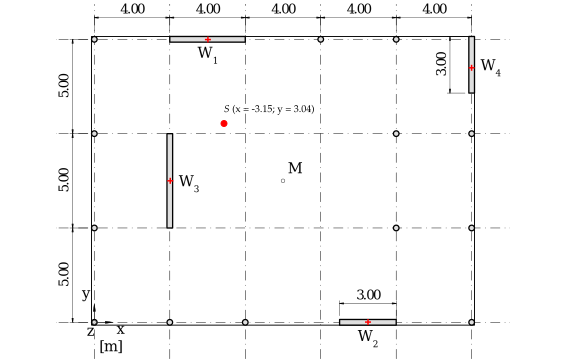

In [13]:
#| label: fig-ekv_darstellung_berechnung
#| fig-cap: "Grundriss mit Schubmittelpunkt"

import svgutils.compose as sc
from IPython.display import SVG



##Wandschwerpunkte
x_i_plot = [x.subs(params)/unit.m for x in x_i]
y_i_plot = [y.subs(params)/unit.m for y in y_i]


##Plattenrand
platte_x = [-sp.Rational(2.5)*L_x, sp.Rational(2.5)*L_x,
            sp.Rational(2.5)*L_x, -sp.Rational(2.5)*L_x,
            -sp.Rational(2.5)*L_x]
platte_y = [-sp.Rational(1.5)*L_y, -sp.Rational(1.5)*L_y,
            sp.Rational(1.5)*L_y, sp.Rational(1.5)*L_y,
            -sp.Rational(1.5)*L_y]

platte_x_plot = [x.subs(params)/unit.m for x in platte_x]
platte_y_plot = [y.subs(params)/unit.m for y in platte_y]


##Schubmittelpunkt
x_c_plot = x_c.subs(params).evalf(3)/unit.m
y_c_plot = y_c.subs(params).evalf(3)/unit.m




# Erstellen Sie den Plot mit angepasster Größe und gleichem Seitenverhältnis der Achsen
fig, ax = plt.subplots(1, figsize=(5.95,5.95))
ax.set_aspect('equal')
ax.scatter(x_i_plot, y_i_plot, color='red', marker='+')
ax.scatter(x_c_plot, y_c_plot, color='red', marker='o')
ax.annotate(f'$S$ (x = {x_c_plot}; y = {y_c_plot})', xy = [x_c_plot*1, y_c_plot*1.2])
ax.axis('off')
fig.savefig('bilder/cover.svg', transparent=True)
plt.close(fig)

# Hier beginnt die Montage mit svgutils und angepasster SVG-Größe
sc.Figure("566.92932", "359.05466",
    sc.Panel(sc.SVG("bilder/aufgabe_ekv_gebaeude_GR.svg").scale(1)),
    sc.Panel(sc.SVG("bilder/cover.svg")).move(101.9,-35.5)
).save("bilder/compose.svg")

SVG('bilder/compose.svg')


### Massenmatrix $M$

![Auslenkung der Massen zur Ermittlung der Matrizen](bilder/aufgabe_mms_3er_auslenk.svg){#fig-mms_ekv_steifigkeit}

### Lastermittlung

Gemäss @SIA261_2020 Ziff. 16.5.2.3 sind ständige und quasiständige Lasten anzusetzen.
Bei der Lastermittlung werden die Gewichtskräfte aus Eigenmassen und Auflasten ermittelt. Dazu werden pro Stockwerk die Gewichtskräfte der Wände definiert. Eine Punktmasse erhält jeweils die Hälfte der darunter- und darüber liegenden Wände. Für die Decke über 2.OG bleibt folglich nur eine Hälfte der Wände.

In [14]:



A_decke = 5*L_x* 3 * L_y
G_decke = A_decke * rho_c* d
G_waende_stock = (L_w1 +L_w2+L_w3+L_w4)*H_1 * rho_c * d
Q_auflast_k = q_auflast_k * A_decke
Q_nutzlast_k = q_nutzlast_k * A_decke
psi_2 = 0.3

params['m_3'] = ((G_decke + Q_auflast_k+ G_waende_stock/2+psi_2 * Q_nutzlast_k)/g).subs(params)
params['m_2'] = ((G_decke + Q_auflast_k+ G_waende_stock+psi_2 * Q_nutzlast_k)/g).subs(params)
params['m_1'] = ((G_decke + Q_auflast_k+ G_waende_stock+psi_2 * Q_nutzlast_k)/g).subs(params)

render.eq_display('A_Decke', A_decke.subs(params).evalf(3),
                  'G_Decke_k', G_decke.subs(params).evalf(3),
                  'G_Waende_k', G_waende_stock.subs(params).evalf(3),
                  'Q_auflast_k', Q_auflast_k.subs(params).evalf(3),
                  'Q_nutzlast_k', Q_nutzlast_k.subs(params).evalf(3),
                  'psi_2', psi_2,
                  )



                     2
A_Decke = 300.0⋅meter 

G_Decke_k = 2.25e+6⋅newton

G_Waende_k = 4.5e+5⋅newton

Q_auflast_k = 3.0e+5⋅newton

Q_nutzlast_k = 6.0e+5⋅newton

ψ₂ = 0.3

Daraus lassen sich die Punktmassen bestimmen:

In [15]:
render.eq_display('m_1', "(G_decke + Q_auflast_k+ G_Waende_k+psi_2 * Q_nutzlast_k)/g",
                 'm_1', m_1.subs(params).evalf(3),
                 'm_2', "(G_decke + Q_auflast_k+ G_Waende_k+psi_2 * Q_nutzlast_k)/g",
                 'm_2', m_2.subs(params).evalf(3),
                 'm_3', "(G_decke + Q_auflast_k+ G_Waende_k/2+psi_2 * Q_nutzlast_k)/g",
                 'm_3', m_3.subs(params).evalf(3))

     G_Waende_k + G_decke + Q_auflast_k + Q_nutzlast_k⋅ψ₂
m₁ = ────────────────────────────────────────────────────
                              g                          

                          2
     3.18e+5⋅newton⋅second 
m₁ = ──────────────────────
             meter         

     G_Waende_k + G_decke + Q_auflast_k + Q_nutzlast_k⋅ψ₂
m₂ = ────────────────────────────────────────────────────
                              g                          

                          2
     3.18e+5⋅newton⋅second 
m₂ = ──────────────────────
             meter         

     G_Waende_k                                          
     ────────── + G_decke + Q_auflast_k + Q_nutzlast_k⋅ψ₂
         2                                               
m₃ = ────────────────────────────────────────────────────
                              g                          

                          2
     2.95e+5⋅newton⋅second 
m₃ = ──────────────────────
             meter         

#### X-Richtung

In [16]:
M_x = sp.Matrix([[m_1,0,0],[0,m_2,0],[0,0,m_3]])

render.eq_display(sp.MatrixSymbol('M_x', 3, 3), M_x,
                  sp.MatrixSymbol('M_x', 3, 3), M_x.subs(params))

     ⎡m₁  0   0 ⎤
     ⎢          ⎥
Mₓ = ⎢0   m₂  0 ⎥
     ⎢          ⎥
     ⎣0   0   m₃⎦

     ⎡                      2                                                 
     ⎢318000.0⋅newton⋅second                                                  
     ⎢───────────────────────             0                        0          
     ⎢         meter                                                          
     ⎢                                                                        
     ⎢                                               2                        
     ⎢                         318000.0⋅newton⋅second                         
Mₓ = ⎢           0             ───────────────────────             0          
     ⎢                                  meter                                 
     ⎢                                                                        
     ⎢                                                                        
     ⎢                                                  295500.0⋅newton⋅second
     ⎢           0                        0         

#### Y-Richtung

In [17]:
M_y = sp.Matrix([[m_1,0,0],[0,m_2,0],[0,0,m_3]])

render.eq_display(sp.MatrixSymbol('M_y', 3, 3), M_y,
                  sp.MatrixSymbol('M_y', 3, 3), M_y.subs(params))

      ⎡m₁  0   0 ⎤
      ⎢          ⎥
M_y = ⎢0   m₂  0 ⎥
      ⎢          ⎥
      ⎣0   0   m₃⎦

      ⎡                      2                                                
      ⎢318000.0⋅newton⋅second                                                 
      ⎢───────────────────────             0                        0         
      ⎢         meter                                                         
      ⎢                                                                       
      ⎢                                               2                       
      ⎢                         318000.0⋅newton⋅second                        
M_y = ⎢           0             ───────────────────────             0         
      ⎢                                  meter                                
      ⎢                                                                       
      ⎢                                                                       
      ⎢                                                  295500.0⋅newton⋅secon
      ⎢           0                        0        

### Steifigkeitsmatrix $K$

#### X-Richtung

Aufgrund der gelenkigen Verbindung zwischen Platten und Wände gilt für die Ersatzsteifigkeit:

$$
k = \frac{3EI}{H^3}
$${#eq-ekv_ersatzsteifigkeit}

Die Biegesteifigkeit $EI$ wird um den Faktor $\gamma_{EI}$ reduziert zur Berücksichtigung der Rissbildung. Zusätzlich gilt, die Ersatzsteifigkeit in X-Richtung entspricht $EI_y$. Dazu wird für $H$ die entsprechende Höhe ab Einspannhorizont eingesetzt.

In [18]:
params[H] = (H_1+H_2+H_3).subs(params)
k_1_x = 3 * EI_y*gamma_EI / (H_1)**3
k_2_x = 3 * EI_y*gamma_EI / (H_1+H_2)**3 
k_3_x = 3 * EI_y*gamma_EI / (H_1+H_2+H_3)**3

render.eq_display(
'k_1_x', '3 * EI_y*gamma_EI / (H_1)**3',
'k_1_x', k_1_x.subs(params).simplify().evalf(3),
'k_2_x', '3 * EI_y*gamma_EI / (H_1+H_2)**3',
'k_2_x', k_2_x.subs(params).simplify().evalf(3),
'k_3_x', '3 * EI_y*gamma_EI / (H_1+H_2+H_3)**3', 
'k_3_x', k_3_x.subs(params).simplify().evalf(3))

       3⋅EI_y⋅γ_EI
k₁ ₓ = ───────────
             3    
           H₁     

       3.22e+9⋅newton
k₁ ₓ = ──────────────
           meter     

       3⋅EI_y⋅γ_EI
k₂ ₓ = ───────────
                 3
        (H₁ + H₂) 

       4.03e+8⋅newton
k₂ ₓ = ──────────────
           meter     

         3⋅EI_y⋅γ_EI  
k₃ ₓ = ───────────────
                     3
       (H₁ + H₂ + H₃) 

       1.19e+8⋅newton
k₃ ₓ = ──────────────
           meter     

Abgefüllt in die Steifigkeitsmatrix

In [19]:
K_x = sp.Matrix([[k_1_x + k_2_x, -k_2_x, 0],[-k_2_x,k_2_x+k_3_x, -k_3_x], [0,-k_3_x, k_3_x]])

render.eq_display(
    sp.MatrixSymbol('K_x', 3, 3), "Matrix([[k_1_x + k_2_x, -k_2_x, 0],[-k_2_x,k_2_x+k_3_x, -k_3_x], [0,-k_3_x, k_3_x]])",
    sp.MatrixSymbol('K_x', 3, 3), sp.simplify(K_x.subs(params)).evalf(3)
)

     ⎡k₁ ₓ + k₂ ₓ     -k₂ ₓ       0  ⎤
     ⎢                               ⎥
Kₓ = ⎢   -k₂ ₓ     k₂ ₓ + k₃ ₓ  -k₃ ₓ⎥
     ⎢                               ⎥
     ⎣     0          -k₃ ₓ     k₃ ₓ ⎦

     ⎡ 3.63e+9⋅newton   -4.03e+8⋅newton                   ⎤
     ⎢ ──────────────   ────────────────         0        ⎥
     ⎢     meter             meter                        ⎥
     ⎢                                                    ⎥
     ⎢-4.03e+8⋅newton    5.23e+8⋅newton   -1.19e+8⋅newton ⎥
Kₓ = ⎢────────────────   ──────────────   ────────────────⎥
     ⎢     meter             meter             meter      ⎥
     ⎢                                                    ⎥
     ⎢                  -1.19e+8⋅newton    1.19e+8⋅newton ⎥
     ⎢       0          ────────────────   ────────────── ⎥
     ⎣                       meter             meter      ⎦

#### Y-Richtung

In [20]:
k_1_y = 3 * EI_x*gamma_EI / H_1**3
k_2_y = 3 * EI_x*gamma_EI / (H_1+H_2)**3
k_3_y = 3 * EI_x*gamma_EI / (H_1+H_2+H_3)**3

render.eq_display(
'k_1_y', k_1_y.subs(params).simplify().evalf(3),
'k_2_y', k_2_y.subs(params).simplify().evalf(3),
'k_3_y', k_3_y.subs(params).simplify().evalf(3))

        5.37e+9⋅newton
k_1_y = ──────────────
            meter     

        6.71e+8⋅newton
k_2_y = ──────────────
            meter     

        1.99e+8⋅newton
k_3_y = ──────────────
            meter     

Abgefüllt in die Steifigkeitsmatrix

In [21]:
K_y = sp.Matrix([[k_1_y + k_2_y, -k_2_y, 0],[-k_2_y,k_2_y+k_3_y, -k_3_y], [0,-k_3_y, k_3_y]])

render.eq_display(
    sp.MatrixSymbol('K_y', 3, 3), "Matrix([[k_1_y + k_2_y, -k_2_y, 0],[-k_2_y,k_2_y+k_3_y, -k_3_y], [0,-k_3_y, k_3_y]])",
    sp.MatrixSymbol('K_y', 3, 3), sp.simplify(K_y.subs(params)).evalf(3)
)

      ⎡k_1_y + k_2_y     -k_2_y        0   ⎤
      ⎢                                    ⎥
K_y = ⎢   -k_2_y      k_2_y + k_3_y  -k_3_y⎥
      ⎢                                    ⎥
      ⎣      0           -k_3_y      k_3_y ⎦

      ⎡ 6.04e+9⋅newton   -6.71e+8⋅newton                   ⎤
      ⎢ ──────────────   ────────────────         0        ⎥
      ⎢     meter             meter                        ⎥
      ⎢                                                    ⎥
      ⎢-6.71e+8⋅newton    8.7e+8⋅newton    -1.99e+8⋅newton ⎥
K_y = ⎢────────────────   ─────────────    ────────────────⎥
      ⎢     meter             meter             meter      ⎥
      ⎢                                                    ⎥
      ⎢                  -1.99e+8⋅newton    1.99e+8⋅newton ⎥
      ⎢       0          ────────────────   ────────────── ⎥
      ⎣                       meter             meter      ⎦

### Eigenkreisfrequenzen 
Bei einem Mehrmassenschwinger gibt es entsprechend den Freiheitsgraden Eigenkreisfrequenzen $\omega_n$. Diese lassen sich anhand folgender Gleichung bestimmen:

$$
\det{[\mathbf{K}-\omega_n^2 \mathbf{M}]=0}
$${#eq-ekv_eigenkreisfreqs}

#### X-Richtung

In [22]:
params_plot = convert.param_value(params)

eq_omega = sp.det((K_x-omega_n**2*M_x).subs(params_plot))
omega_n_solve= sp.solve([eq_omega.subs(params_plot).simplify(), omega_n<=5000, omega_n>=0], omega_n, dict=True)

omega_1_x = omega_n_solve.args[0].rhs/unit.second
omega_2_x = omega_n_solve.args[1].rhs/unit.second
omega_3_x = omega_n_solve.args[2].rhs/unit.second



render.eq_display('omega_1_x', omega_1_x.evalf(3),
                  'omega_2_x', omega_2_x.evalf(3),
                  'omega_3_x', omega_3_x.evalf(3))



        16.7 
ω₁ ₓ = ──────
       second

        40.1 
ω₂ ₓ = ──────
       second

       108.0 
ω₃ ₓ = ──────
       second

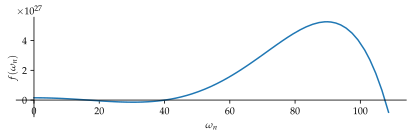

In [23]:
#| label: fig-loesung_eigenkreisfrequenzen_x
#| fig-cap: Nullstellen der @eq-ekv_eigenkreisfreqs in X-Richtung
          
sp.plot(eq_omega.subs(params_plot).evalf(5).simplify(),(omega_n, 0, max([omega_1_x,omega_2_x,omega_3_x])*unit.second*1.01),size=(5.9,2), show=False).show()

#### Y-Richtung

In [24]:
eq_omega =  sp.det((K_y-omega_n**2*M_y).subs(params_plot))
omega_n_solve= sp.solve([eq_omega.subs(params_plot).simplify(), omega_n<=5000, omega_n>=0], omega_n, dict=True)

omega_1_y = omega_n_solve.args[0].rhs/unit.second
omega_2_y = omega_n_solve.args[1].rhs/unit.second
omega_3_y = omega_n_solve.args[2].rhs/unit.second



render.eq_display('omega_1_y', omega_1_y.evalf(3),
                  'omega_2_y', omega_2_y.evalf(3),
                  'omega_3_y', omega_3_y.evalf(3))



         21.6 
ω_1_y = ──────
        second

         51.7 
ω_2_y = ──────
        second

        139.0 
ω_3_y = ──────
        second

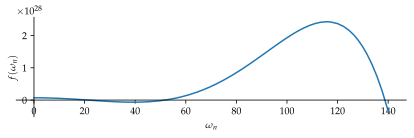

In [25]:
#| label: fig-loesung_eigenkreisfrequenzen_y
#| fig-cap: Nullstellen der @eq-ekv_eigenkreisfreqs in Y-Richtung
          
sp.plot(eq_omega.subs(params_plot).evalf(5).simplify(),(omega_n, 0, max([omega_1_y,omega_2_y,omega_3_y])*unit.second*1.01),size=(5.9,2), show=False).show()

### Eigenperioden

Die Eigenperioden lassen sich aus den Eigenkreisfrequenzen bestimmen. Das Ersatzkraftverfahren betrachtet lediglich die Grundfrequenz. Weitere Schwingformen werden vernachlässigt. Aus diesem Grund sind in @SIA261_2020
Abs. 16.5.2 Einschränkungen bei der Anwendung des Ersatzkraftverfahrens aufgelistet. Ziel dieser Einschränkungen ist es, dass lediglich Bauwerke untersucht werden, welche massgeblich in der Grundfrequenz schwingen.

$$
T = \frac{2\pi}{\omega_1}
$${#eq-ekv_eigenperiode}



#### X-Richtung 

Nach @SIA261_2020 16.5.2.3

In [26]:
T_1_x_approx = 2*sp.sqrt(58.2/1000)*unit.second
render.eq_display('T_1_x_approx', T_1_x_approx.subs(params).evalf(3))

T₁ ₓ ₐₚₚᵣₒₓ = 0.482⋅second

Durch die ermittelte Grundfrequenz

In [27]:
print(EI_y.subs(params).simplify()/1000)

68790000.0*meter**2*newton


In [28]:
T_1_x = (2*sp.pi) / omega_1_x
render.eq_display('T_1_x', T_1_x.subs(params).evalf(3))

T₁ ₓ = 0.376⋅second

#### Y-Richtung

Nach @SIA261_2020 16.5.2.3

In [29]:
T_1_y_approx = 2*sp.sqrt(34.9/1000)*unit.second
render.eq_display('T_1_y_approx', T_1_y_approx.subs(params).evalf(3))

T_1_y_approx = 0.374⋅second

Durch die ermittelte Grundfrequenz

In [30]:
T_1_y = (2*sp.pi) / omega_1_y

render.eq_display('T_1_y', T_1_y.subs(params).evalf(3))

T_1_y = 0.291⋅second

### Pseudobeschleunigung

Es wird für die Eigenperioden die Pseudobeschleunigung bestimmt. Siehe dazu @SIA261_2020.



In [31]:
a_gd = 1.0 *unit.m/unit.second**2

render.eq_display('a_gd', a_gd)

       1.0⋅meter
a_gd = ─────────
              2 
        second  

#### X-Richtung

In [32]:
S_e_x = antwortspektrum(a_gd, T_1_x.subs(params).evalf(3), Baugrundklasse='B')
render.eq_display('S_e_x', S_e_x.evalf(3))

|   |   |
|---|---|
| $S = 1.2$ | $T_{B} = 0.08 \text{s}$ |
| $T_{C} = 0.35 \text{s}$ | $T_{D} = 2.0 \text{s}$ |
| $\eta = 1$ | |


     2.5⋅S⋅T_C⋅a_gd⋅η
Sₑ = ────────────────
            T        

       2.8⋅meter
Sₑ ₓ = ─────────
              2 
        second  

#### Y-Richtung

In [33]:
S_e_y = antwortspektrum(a_gd, T_1_y.subs(params).evalf(3), Baugrundklasse='B')
render.eq_display('S_e_y', S_e_y.evalf(3))

|   |   |
|---|---|
| $S = 1.2$ | $T_{B} = 0.08 \text{s}$ |
| $T_{C} = 0.35 \text{s}$ | $T_{D} = 2.0 \text{s}$ |
| $\eta = 1$ | |


Sₑ = 2.5⋅S⋅a_gd⋅η

        3.0⋅meter
S_e_y = ─────────
               2 
         second  

### Bemessungsspektrum

#### X-Richtung

In [34]:
S_d_x = bemessungsspektrum(a_gd, T_1_x.subs(params).evalf(3), params['q'], params['gamma_f'],Baugrundklasse='B')
render.eq_display('S_d_x', S_d_x.evalf(3))

|   |   |
|---|---|
| $S = 1.2$ | $T_{B} = 0.08 \text{s}$ |
| $T_{C} = 0.35 \text{s}$ | $T_{D} = 2.0 \text{s}$ |
| $a_{gd} = \frac{1.0 \text{m}}{\text{s}^{2}}$ | $g = \frac{10.0 \text{m}}{\text{s}^{2}}$ |
| $\gamma_{f} = 1.0$ | $q = 2.0$ |


      2.5⋅S⋅T_C⋅a_gd⋅γ_f
S_d = ──────────────────
            T⋅g⋅q       

S_d_x = 0.14

#### Y-Richtung

In [35]:
S_d_y = bemessungsspektrum(a_gd, T_1_y.subs(params).evalf(3), params['q'], params['gamma_f'],Baugrundklasse='B')
render.eq_display('S_d_y', S_d_y.evalf(3))

|   |   |
|---|---|
| $S = 1.2$ | $T_{B} = 0.08 \text{s}$ |
| $T_{C} = 0.35 \text{s}$ | $T_{D} = 2.0 \text{s}$ |
| $a_{gd} = \frac{1.0 \text{m}}{\text{s}^{2}}$ | $g = \frac{10.0 \text{m}}{\text{s}^{2}}$ |
| $\gamma_{f} = 1.0$ | $q = 2.0$ |


      2.5⋅S⋅a_gd⋅γ_f
S_d = ──────────────
           g⋅q      

S_d_y = 0.15

### Stockwerkquerkraft

Die Stockwerksquerkraft resultiert nach Norm aus @eq-ekv_v_stock. Es wird lediglich die Nutzlast berücksichtigt. Zusätzlich ist zwischen beiden Richtungen zu unterscheiden. 

$$
F_d = S_d \cdot \sum_{j=1} (G_k + \psi_2 \cdot Q_k)_j
$${#eq-ekv_v_stock}

Aufgeteilt auf die Geschosse wird diese nach @eq-ekv_aufteilung.

$$
F_{d,i} = \frac{z_i \sum_{i=1} (G_k + \psi_2 \cdot Q_k)_i}{\sum_{j=1} z_j\cdot(G_k + \psi_2 \cdot Q_k)_j} \cdot F_d
$${#eq-ekv_aufteilung}

Der Term der @eq-ekv_term_massen entspricht den Punktmassen.

$$
G_k + \psi_2 \cdot Q_k
$${#eq-ekv_term_massen}

Die Ersatzkraft greift am Massenschwerpunkt der Decke an. Diese gilt es ins Steifigkeitszentrum zu verschieben. Darus resultiert ein Torsionsmoment.

#### X-Richtung

In [36]:
F_d_x = np.sum(np.array([m_1, m_2, m_3])*g*S_d_x)
render.eq_display('F_d_x', F_d_x.subs(params).evalf(3))

F_d_x = 1.3e+6⋅newton

In [37]:
H_masse_i = np.array([(H_1) * m_1,(H_1+H_2) * m_2,(H_1+H_2+H_3) * m_3])

V_x_i = H_masse_i / np.sum(H_masse_i) * F_d_x

V_x_i_dict = {f'V_x{i+1}': V_x_i[i].subs(params).evalf(3) for i in range(len(V_x_i))}
render.dict_to_table(V_x_i_dict)


|   |   |
|---|---|
| $V_{x1} = 2.25 \cdot 10^{5} \text{N}$ | $V_{x2} = 4.5 \cdot 10^{5} \text{N}$ |
| $V_{x3} = 6.27 \cdot 10^{5} \text{N}$ | |


#### Y-Richtung

In [38]:
F_d_y = np.sum(np.array([m_1, m_2, m_3])*g*S_d_y)
render.eq_display('F_d_y', F_d_y.subs(params).evalf(3))

F_d_y = 1.4e+6⋅newton

In [39]:
V_y_i = H_masse_i / np.sum(H_masse_i) * F_d_y


V_y_i_dict = {f'V_y{i+1}': V_y_i[i].subs(params).evalf(3) for i in range(len(V_y_i))}
render.dict_to_table(V_y_i_dict)

|   |   |
|---|---|
| $V_{y1} = 2.41 \cdot 10^{5} \text{N}$ | $V_{y2} = 4.83 \cdot 10^{5} \text{N}$ |
| $V_{y3} = 6.73 \cdot 10^{5} \text{N}$ | |


### Wandkoordinaten zum Schubmittelpunkt

Der Ursprung des Koordinatensystems wird in das Steifigkeitszentrum gelegt. 

In [40]:
x_i_star = x_i-x_c

x_i_star_dict = {f'x{i+1}': x_i_star[i].subs(params).evalf(3) for i in range(len(x_i_star))}
render.dict_to_table(x_i_star_dict)

|   |   |
|---|---|
| $x_{1} = - 0.854 \text{m}$ | $x_{2} = 7.65 \text{m}$ |
| $x_{3} = - 2.85 \text{m}$ | $x_{4} = 13.1 \text{m}$ |


In [41]:
y_i_star = y_i - y_c

y_i_star_dict = {f'y{i+1}': y_i_star[i].subs(params).evalf(3) for i in range(len(y_i_star))}
render.dict_to_table(y_i_star_dict)


|   |   |
|---|---|
| $y_{1} = 4.46 \text{m}$ | $y_{2} = - 10.5 \text{m}$ |
| $y_{3} = - 3.04 \text{m}$ | $y_{4} = 2.96 \text{m}$ |


### Stockwerkstorsion

Beachte die Vorzeichenkonvention: Das Torsionsmoment ist positiv im Gegenuhrzeigersinn.

Nach Norm [@SIA261_2020] 16.5.3.4 ist die Exzentrizität (Schubmittelpunkt zu Massenschwerpunkt) anhand der Gebäudeabmessungen zu erhöhen.

$$
e_{d,sup} = 1.5\cdot e+0.05\cdot b
$${#eq-ekv_exzentr_sup}

$$
e_{d,inf} = 0.5\cdot e-0.05\cdot b
$${#eq-ekv_exzentr_inf}

$b$ Gebäudebreite in der entsprechenden Kraftrichtung

$e$ Exzentrizität

Aus den entstehenden 4 Lastfällen ist der ungünstigste massgebend. Es wird lediglich $e_{d,sup}$ betrachtet.

#### X-Richtung

In [42]:
e_d_y_sup = sp.Abs(y_c) * 1.5+0.05*3*L_y

render.eq_display('e_dysup', e_d_y_sup.subs(params).evalf(3))

e_dysup = 5.31⋅meter

In [43]:
T_x_i = V_x_i * e_d_y_sup

T_x_i_dict = {f'T_x{i+1}': T_x_i[i].subs(params).evalf(3) for i in range(len(T_x_i))}
render.dict_to_table(T_x_i_dict)



|   |   |
|---|---|
| $T_{x1} = 1.2 \cdot 10^{6} \text{m} \text{N}$ | $T_{x2} = 2.39 \cdot 10^{6} \text{m} \text{N}$ |
| $T_{x3} = 3.33 \cdot 10^{6} \text{m} \text{N}$ | |


#### Y-Richtung

In [44]:
e_d_x_sup = sp.Abs(x_c) * 1.5+0.05*5*L_x

render.eq_display('e_dxsup', e_d_x_sup.subs(params).evalf(3))

e_dxsup = 5.72⋅meter

In [45]:
T_y_i = V_y_i * e_d_x_sup

T_y_i_dict = {f'T_y{i+1}': T_y_i[i].subs(params).evalf(3) for i in range(len(T_y_i))}
render.dict_to_table(T_y_i_dict)


|   |   |
|---|---|
| $T_{y1} = 1.38 \cdot 10^{6} \text{m} \text{N}$ | $T_{y2} = 2.76 \cdot 10^{6} \text{m} \text{N}$ |
| $T_{y3} = 3.85 \cdot 10^{6} \text{m} \text{N}$ | |


### Wandquerkraft

Die Kräfte wirken jeweils parallel zur Wandebene. Die Beanspruchung der einzelnen Wandscheiben durch die Stockwerkquerkraft $V_{xi}$ oder $V_{yi}$ setzt sich aus einem Translationsanteil (Querkraft) und einem Rotationsanteil (Torsion) zusammen. Diese können sich im Grundriss günstig oder ungünstig überlagern.

Der Kraftanteil wird durch @eq-ekv_kraftanteil_x und @eq-ekv_kraftanteil_y bestimmt.

$$
F_{x,i} = \frac{V_{x} \cdot I_{yi}}{\sum_{i=1}^n I_{y,i}} - T_{x} \cdot \frac{I_{y,i} \cdot y_i^\star}{\sum (I_{x,i} \cdot x_i^{\star 2}) + ( I_{y,i} \cdot y_i^{\star 2})}
$${#eq-ekv_kraftanteil_x}

$$
F_{y,i} = \frac{V_{y} \cdot I_{xi}}{\sum_{i=1}^n I_{x,i}} + T_{y} \cdot \frac{I_{x,i} \cdot x_i^\star}{\sum (I_{x,i} \cdot x_i^{\star 2}) + ( I_{y,i} \cdot y_i^{\star 2})}
$${#eq-ekv_kraftanteil_y}

Dabei kann @eq-ekv_woelbmoment als Wölbmoment interpretiert werden.

$$
\sum (I_{x,i} \cdot x_i^{\star 2}) + ( I_{y,i} \cdot y_i^{\star 2})
$${#eq-ekv_woelbmoment}

Wichtig ist dabei die Unterscheidung anhand der Ausrichtung der Wand. Als Beispiel wird für eine Einwirkung in X-Richtung für Wand 1 und Wand 2 die @eq-ekv_kraftanteil_x verwendet und für die Wand 3 und Wand 4 @eq-ekv_kraftanteil_y mit Einwirkung $V_y = 0$ und für $T_y$ wird $T_x$ eingesetzt.

Die dargestellten Resultate entsprechen den Einwirkungen auf die Wandscheiben pro Stockwerk. Zur Ermittlung der Wandquerkraft im EG sind sämtliche Stockwerkquerkrafte zu addieren.

In [46]:
def kraft_plot(kraft_vektor,torsionsmoment, querkraft, name='test', richtung='X'):
    
    from matplotlib.patches import FancyArrowPatch


# Erstellen Sie den Plot mit angepasster Größe und gleichem Seitenverhältnis der Achsen
    fig, ax = plt.subplots(1, figsize=(6.05,6.05))
    ax.set_aspect('equal')


    
    # Wandmittelpunkte
    ax.scatter(x_i_plot, y_i_plot, color='red', marker='+')


    
    # Kraft-Vektoren
    forces = np.float64(kraft_vektor/unit.N)
    for i, (x, y) in enumerate(zip(x_i_plot, y_i_plot)):
        if i < 2:
            ax.arrow(x, y, forces[i]/abs(forces[i]), 0, head_width=0.3, head_length=0.7, fc='orange', ec='orange', linewidth=3)
            ax.text(x + forces[i]/abs(forces[i]), y + 0.5, f'{abs(forces[i])/1000} kN', fontsize=12, color='orange')
        else:
            ax.arrow(x, y, 0, forces[i]/abs(forces[i]), head_width=0.3, head_length=0.7, fc='orange', ec='orange', linewidth=3)
            ax.text(x + 0.5, y + forces[i]/abs(forces[i]), f'{abs(forces[i])/1000} kN', fontsize=12, color='orange')


    
    # Einwirkungen
    arrow = FancyArrowPatch((-0.8, 0), (0, -0.8), connectionstyle="arc3,rad=0.8", arrowstyle="Simple,tail_width=0.3,head_width=4,head_length=8", color="red")
    ax.add_patch(arrow)
    ax.text(-2, -2, f'{np.round(torsionsmoment/1000,1)} kNm', fontsize=12, color='red')
    
    
    if richtung == 'X':
        ax.arrow(0, 0, querkraft/ abs(querkraft), 0, head_width=0.3, head_length=0.7, fc='red', ec='red', linewidth=3)
        ax.text(0 + 1, 0 + 1, f'{np.round(querkraft/1000,1)} kN', fontsize=12, color='red')
        
    if richtung == 'Y':
        ax.arrow(0, 0, 0,querkraft/ abs(querkraft), head_width=0.3, head_length=0.7, fc='red', ec='red', linewidth=3)
        ax.text(0 + 1, 0 + 1, f'{np.round(querkraft/1000,1)} kN', fontsize=12, color='red')
    

    
    ax.axis('off')
    fig.savefig(f'bilder/{name}_Vektoren.svg', transparent=True)
    plt.close(fig)
    
    # Hier beginnt die Montage mit svgutils und angepasster SVG-Größe
    sc.Figure("566.92932", "359.05466",
        sc.Panel(sc.SVG("bilder/aufgabe_ekv_gebaeude_GR.svg").scale(1)),
        sc.Panel(sc.SVG(f'bilder/{name}_Vektoren.svg')).move(98,-39)
    ).save(f'bilder/{name}_Vektoren_GR.svg')
    
    display(SVG(f'bilder/{name}_Vektoren_GR.svg'))

#### X-Richtung

In [47]:
Wandkraft_i_durch_V_x = np.array([])
Wandkraft_durch_V_x_list = []
for j in range(0,len(V_x_i)):

    Wandkraft_12_durch_V_x = (V_x_i[j] * I_y_i[0:2] / np.sum(I_y_i)) - T_x_i[j] * (I_y_i[0:2]*y_i_star[0:2])/ np.sum((I_x_i*x_i_star**2)+(I_y_i*y_i_star**2))
    
    Wandkraft_34_durch_V_x =  T_x_i[j] * (I_x_i[2:]*x_i_star[2:])/ np.sum((I_x_i*x_i_star**2)+(I_y_i*y_i_star**2))

    Wandkraft_durch_V_x = np.concatenate((Wandkraft_12_durch_V_x,Wandkraft_34_durch_V_x))
    Wandkraft_i_durch_V_x = np.append(Wandkraft_i_durch_V_x, [Wandkraft_durch_V_x[i].subs(params).evalf(3) for i in range(len(Wandkraft_durch_V_x))])

    
    Wandkraft_durch_V_x_dict = {f'F_x_{j+1}{i+1}': Wandkraft_durch_V_x[i].subs(params).evalf(3) for i in range(len(Wandkraft_durch_V_x))}
    Wandkraft_durch_V_x_list.append(Wandkraft_durch_V_x_dict)

In [48]:
render.dict_to_table(Wandkraft_durch_V_x_list[0])

|   |   |
|---|---|
| $F_{x 11} = 1.23 \cdot 10^{5} \text{N}$ | $F_{x 12} = 1.0 \cdot 10^{5} \text{N}$ |
| $F_{x 13} = - 4.27 \cdot 10^{4} \text{N}$ | $F_{x 14} = 4.25 \cdot 10^{4} \text{N}$ |


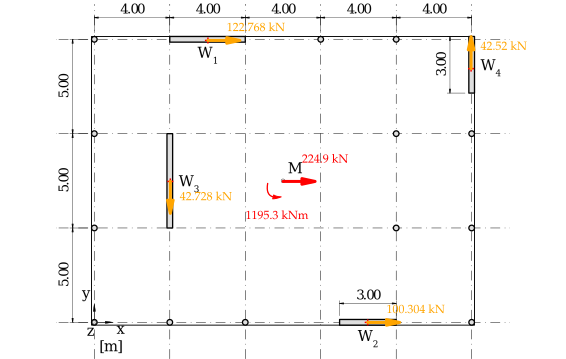

In [49]:
#| label: fig-ekv_Vx_erster_Stock
#| fig-cap: "Scheibenkräfte im EG durch die Kraft in X-Richtung"

kraft_plot(Wandkraft_i_durch_V_x[0:4],np.float64(T_x_i_dict['T_x1']/unit.m/unit.N),np.float64(V_x_i_dict['V_x1']/unit.N),  name='V_x_stock_1', richtung='X')

{{< pagebreak >}}

In [50]:
render.dict_to_table(Wandkraft_durch_V_x_list[1])

|   |   |
|---|---|
| $F_{x 21} = 2.46 \cdot 10^{5} \text{N}$ | $F_{x 22} = 2.01 \cdot 10^{5} \text{N}$ |
| $F_{x 23} = - 8.55 \cdot 10^{4} \text{N}$ | $F_{x 24} = 8.5 \cdot 10^{4} \text{N}$ |


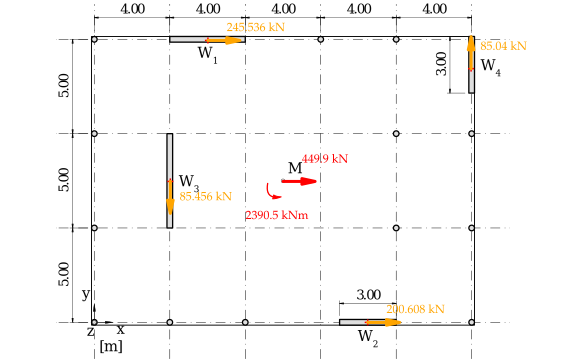

In [51]:
#| label: fig-ekv_Vx_1og
#| fig-cap: "Scheibenkräfte im 1.OG durch die Kraft in X-Richtung"

kraft_plot(Wandkraft_i_durch_V_x[4:8],np.float64(T_x_i_dict['T_x2']/unit.m/unit.N),np.float64(V_x_i_dict['V_x2']/unit.N),  name='V_x_stock_2', richtung='X')

{{< pagebreak >}}

In [52]:
render.dict_to_table(Wandkraft_durch_V_x_list[2])

|   |   |
|---|---|
| $F_{x 31} = 3.42 \cdot 10^{5} \text{N}$ | $F_{x 32} = 2.8 \cdot 10^{5} \text{N}$ |
| $F_{x 33} = - 1.19 \cdot 10^{5} \text{N}$ | $F_{x 34} = 1.19 \cdot 10^{5} \text{N}$ |


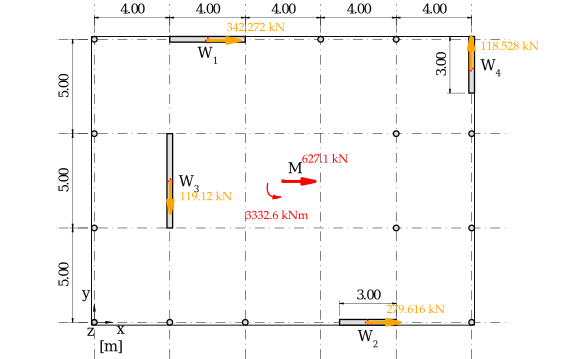

In [53]:
#| label: fig-ekv_Vx_2og
#| fig-cap: "Scheibenkräfte im 2.OG durch die Kraft in X-Richtung"

kraft_plot(Wandkraft_i_durch_V_x[8:],np.float64(T_x_i_dict['T_x3']/unit.m/unit.N),np.float64(V_x_i_dict['V_x3']/unit.N),  name='V_x_stock_3', richtung='X')

{{< pagebreak >}}

#### Y-Richtung

In [54]:
Wandkraft_i_durch_V_y = np.array([])
Wandkraft_durch_V_y_list = []
for j in range(0,len(V_y_i)):

    Wandkraft_34_durch_V_y = (V_y_i[j] * I_x_i[2:] / np.sum(I_x_i)) + T_y_i[j] * (I_x_i[2:]*x_i_star[2:])/ np.sum((I_x_i*x_i_star**2)+(I_y_i*y_i_star**2))
    
    Wandkraft_12_durch_V_y =  -T_y_i[j] * (I_y_i[0:2]*y_i_star[0:2])/ np.sum((I_x_i*x_i_star**2)+(I_y_i*y_i_star**2))

    Wandkraft_durch_V_y = np.concatenate((Wandkraft_12_durch_V_y,Wandkraft_34_durch_V_y),axis=0)
    Wandkraft_i_durch_V_y = np.append(Wandkraft_i_durch_V_y, [Wandkraft_durch_V_y[i].subs(params).evalf(3) for i in range(len(Wandkraft_durch_V_y))])

    Wandkraft_durch_V_y_dict = {f'F_y_{j+1}{i+1}': Wandkraft_durch_V_y[i].subs(params).evalf(3) for i in range(len(Wandkraft_durch_V_y))}
    Wandkraft_durch_V_y_list.append(Wandkraft_durch_V_y_dict)

In [55]:
render.dict_to_table(Wandkraft_durch_V_y_list[0])

|   |   |
|---|---|
| $F_{y 11} = - 3.95 \cdot 10^{4} \text{N}$ | $F_{y 12} = 3.94 \cdot 10^{4} \text{N}$ |
| $F_{y 13} = 1.48 \cdot 10^{5} \text{N}$ | $F_{y 14} = 9.18 \cdot 10^{4} \text{N}$ |


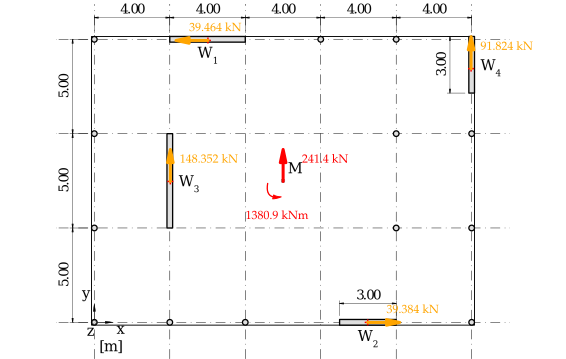

In [56]:
#| label: fig-ekv_Vy_eg
#| fig-cap: "Scheibenkräfte im EG durch die Kraft in Y-Richtung"

kraft_plot(Wandkraft_i_durch_V_y[0:4],np.float64(T_y_i_dict['T_y1']/unit.m/unit.N),np.float64(V_y_i_dict['V_y1']/unit.N),  name='V_y_stock_1', richtung='Y')

{{< pagebreak >}}

In [57]:
render.dict_to_table(Wandkraft_durch_V_y_list[1])

|   |   |
|---|---|
| $F_{y 21} = - 7.89 \cdot 10^{4} \text{N}$ | $F_{y 22} = 7.88 \cdot 10^{4} \text{N}$ |
| $F_{y 23} = 2.97 \cdot 10^{5} \text{N}$ | $F_{y 24} = 1.84 \cdot 10^{5} \text{N}$ |


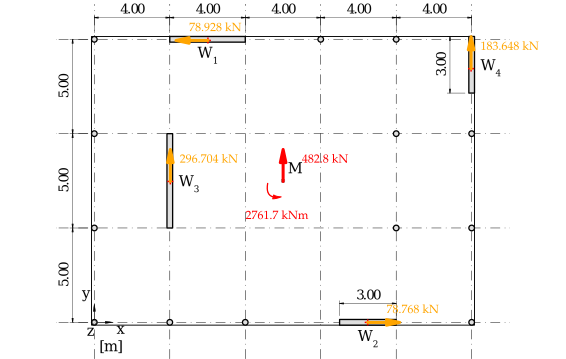

In [58]:
#| label: fig-ekv_Vy_1og
#| fig-cap: "Scheibenkräfte im 1.OG durch die Kraft in Y-Richtung"

kraft_plot(Wandkraft_i_durch_V_y[4:8],np.float64(T_y_i_dict['T_y2']/unit.m/unit.N),np.float64(V_y_i_dict['V_y2']/unit.N),  name='V_y_stock_2', richtung='Y')

{{< pagebreak >}}

In [59]:
render.dict_to_table(Wandkraft_durch_V_y_list[2])

|   |   |
|---|---|
| $F_{y 31} = - 1.1 \cdot 10^{5} \text{N}$ | $F_{y 32} = 1.1 \cdot 10^{5} \text{N}$ |
| $F_{y 33} = 4.14 \cdot 10^{5} \text{N}$ | $F_{y 34} = 2.56 \cdot 10^{5} \text{N}$ |


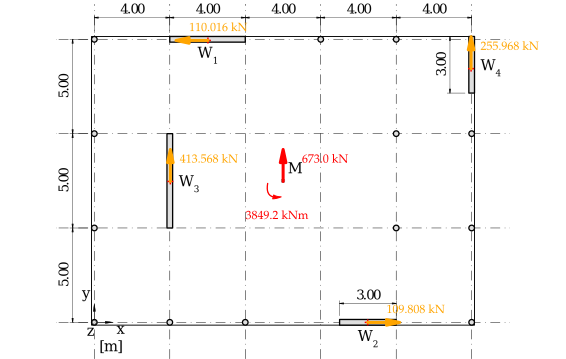

In [60]:
#| label: fig-ekv_Vy_2og
#| fig-cap: "Scheibenkräfte im 2.OG durch die Kraft in Y-Richtung"

kraft_plot(Wandkraft_i_durch_V_y[8:],np.float64(T_y_i_dict['T_y3']/unit.m/unit.N),np.float64(V_y_i_dict['V_y3']/unit.N),  name='V_y_stock_3', richtung='Y')